C:\Users\HP\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(



--- Expériences sur Boston Housing ---
Newton-CG (scipy) - LinearRegression MSE: 0.2877 (temps: 0.01s)

--- LinearRegression avec SGD (lr=0.01) ---
Epoch 0, Loss: 0.883689
Epoch 10, Loss: 0.267503
Epoch 20, Loss: 0.259305
Epoch 30, Loss: 0.262537
Epoch 40, Loss: 0.260762
Epoch 50, Loss: 0.263818
Epoch 60, Loss: 0.260020
Epoch 70, Loss: 0.261150
Epoch 80, Loss: 0.264522
Epoch 90, Loss: 0.262794
Temps total d'entraînement avec SGD : 1.45 secondes
Loss threshold 0.25 non atteint
Test MSE: 0.2970
Test RMSE: 0.5450
Test R²: 0.6581
Temps d'entraînement : 1.45 secondes
Seuil de loss 0.25 non atteint

--- LinearRegression avec SGD (lr=0.001) ---
Epoch 0, Loss: 0.707309
Epoch 10, Loss: 0.294770
Epoch 20, Loss: 0.267967
Epoch 30, Loss: 0.263260
Epoch 40, Loss: 0.261191
Epoch 50, Loss: 0.259282
Epoch 60, Loss: 0.258117
Epoch 70, Loss: 0.257607
Epoch 80, Loss: 0.257344
Epoch 90, Loss: 0.257292
Temps total d'entraînement avec SGD : 1.35 secondes
Loss threshold 0.25 non atteint
Test MSE: 0.2945
Tes

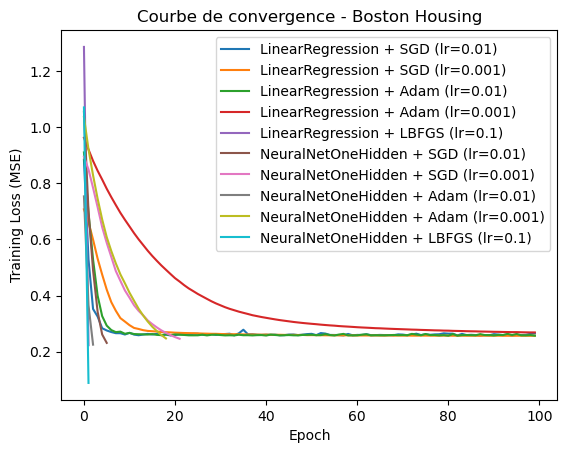


--- Expériences sur California Housing ---
Newton-CG (scipy) - LinearRegression MSE: 0.4175 (temps: 0.02s)

--- LinearRegression avec SGD (lr=0.01) ---
Epoch 0, Loss: 0.467897
Epoch 10, Loss: 1.096960
Epoch 20, Loss: 1.123736
Epoch 30, Loss: 1.029812
Epoch 40, Loss: 1.182717
Epoch 50, Loss: 1.014424
Epoch 60, Loss: 1.069650
Epoch 70, Loss: 1.354572
Epoch 80, Loss: 1.192540
Epoch 90, Loss: 1.076181
Temps total d'entraînement avec SGD : 56.76 secondes
Loss threshold 0.4 non atteint
Test MSE: 0.4194
Test RMSE: 0.6476
Test R²: 0.5739
Temps d'entraînement : 56.76 secondes
Seuil de loss 0.4 non atteint

--- LinearRegression avec SGD (lr=0.001) ---
Epoch 0, Loss: 0.815124
Epoch 10, Loss: 0.519709
Epoch 20, Loss: 0.711350
Epoch 30, Loss: 0.868697
Epoch 40, Loss: 0.946249
Epoch 50, Loss: 1.003923
Epoch 60, Loss: 1.051269
Epoch 70, Loss: 1.131184
Epoch 80, Loss: 1.129996
Epoch 90, Loss: 1.137840
Temps total d'entraînement avec SGD : 56.86 secondes
Loss threshold 0.4 non atteint
Test MSE: 0.4211

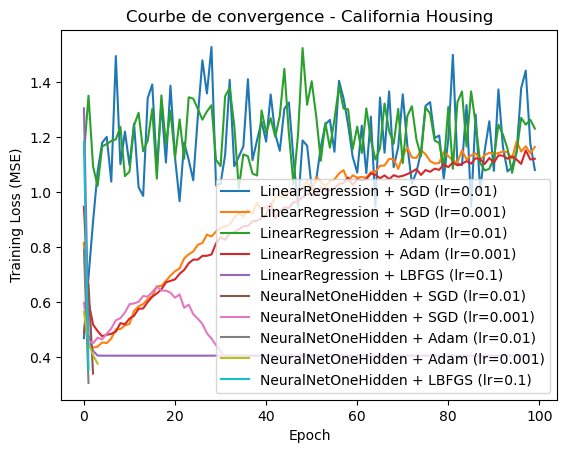

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import fetch_openml, fetch_california_housing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import time

def prepare_boston():
    boston = fetch_openml(name='Boston', version=1, as_frame=True)
    df = boston.frame

    X = df.drop(columns=['MEDV']).copy()
    y = df['MEDV'].copy()

    num_cols = X.select_dtypes(include=np.number).columns
    imputer = SimpleImputer(strategy='median')
    X[num_cols] = imputer.fit_transform(X[num_cols])

    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)

    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1,1))

    return X_scaled, y_scaled, scaler_X, scaler_y

def prepare_california():
    california = fetch_california_housing(as_frame=True)
    df = california.frame

    X = df.drop(columns=['MedHouseVal']).copy()
    y = df['MedHouseVal'].copy()

    num_cols = X.select_dtypes(include=np.number).columns
    imputer = SimpleImputer(strategy='median')
    X[num_cols] = imputer.fit_transform(X[num_cols])

    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)

    scaler_y = StandardScaler()
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1,1))

    return X_scaled, y_scaled, scaler_X, scaler_y

class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
    def forward(self, x):
        return self.linear(x)

class NeuralNetOneHidden(nn.Module):
    def __init__(self, input_dim, hidden_dim=32):
        super().__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        x = self.relu(self.hidden(x))
        return self.output(x)

def train_model(model, optimizer, criterion, train_loader, epochs=100, optimizer_name="", loss_threshold=None):
    model.train()
    losses = []
    start_time = time.time()

    epochs_to_threshold = None

    if optimizer_name == 'LBFGS':
        X_train_all, y_train_all = next(iter(train_loader))  # batch entier
        def closure():
            optimizer.zero_grad()
            outputs = model(X_train_all)
            loss = criterion(outputs, y_train_all)
            loss.backward()
            return loss
        for epoch in range(epochs):
            loss = optimizer.step(closure)
            losses.append(loss.item())
            if loss_threshold is not None and loss.item() < loss_threshold:
                epochs_to_threshold = epoch + 1
                break
    else:
        for epoch in range(epochs):
            epoch_loss = 0
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                epoch_loss += loss.item() * inputs.size(0)
            avg_loss = epoch_loss / len(train_loader.dataset)
            losses.append(avg_loss)
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {avg_loss:.6f}")
            if loss_threshold is not None and avg_loss < loss_threshold:
                epochs_to_threshold = epoch + 1
                break

    end_time = time.time()
    duration = end_time - start_time
    print(f"Temps total d'entraînement avec {optimizer_name} : {duration:.2f} secondes")
    if epochs_to_threshold is not None:
        print(f"Nombre d'epochs pour atteindre loss < {loss_threshold} : {epochs_to_threshold}")
    else:
        print(f"Loss threshold {loss_threshold} non atteint")

    return losses, duration, epochs_to_threshold

def evaluate_model(model, X_tensor, y_tensor):
    model.eval()
    with torch.no_grad():
        pred = model(X_tensor).numpy()
        true = y_tensor.numpy()

        mse = mean_squared_error(true, pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(true, pred)
    return mse, rmse, r2

def newton_cg_scipy(X_train, y_train, X_test, y_test):
    n_samples, n_features = X_train.shape
    X_train_ext = np.hstack([np.ones((n_samples, 1)), X_train])
    X_test_ext = np.hstack([np.ones((X_test.shape[0], 1)), X_test])

    def loss_func(w):
        pred = X_train_ext.dot(w)
        return np.mean((pred - y_train.flatten())**2)

    def grad_func(w):
        pred = X_train_ext.dot(w)
        return 2 * X_train_ext.T.dot(pred - y_train.flatten()) / n_samples

    w0 = np.zeros(n_features + 1)
    start = time.time()
    res = minimize(loss_func, w0, jac=grad_func, method='Newton-CG')
    duration = time.time() - start

    y_pred = X_test_ext.dot(res.x)
    mse = mean_squared_error(y_test, y_pred)
    return mse, duration

def run_all_experiments(X, y, scaler_y, dataset_name):
    print(f"\n--- Expériences sur {dataset_name} ---")

    # Seuil de perte en fonction du dataset
    if dataset_name == "Boston Housing":
        loss_threshold = 0.25
    elif dataset_name == "California Housing":
        loss_threshold = 0.4
    else:
        loss_threshold = 0.25

    # Séparation des données
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    input_dim = X_train.shape[1]

    models = {
        "LinearRegression": LinearRegressionModel(input_dim),
        "NeuralNetOneHidden": NeuralNetOneHidden(input_dim, hidden_dim=32)
    }

    learning_rates = {
        "SGD": [0.01, 0.001],
        "Adam": [0.01, 0.001],
        "LBFGS": [0.1]
    }

    criterion = nn.MSELoss()

    # Optimisation Newton-CG avec Scipy
    mse_newton, dur_newton = newton_cg_scipy(X_train, y_train, X_test, y_test)
    print(f"Newton-CG (scipy) - LinearRegression MSE: {mse_newton:.4f} (temps: {dur_newton:.2f}s)")

    for model_name, model in models.items():
        for opt_name in learning_rates.keys():
            for lr in learning_rates[opt_name]:
                print(f"\n--- {model_name} avec {opt_name} (lr={lr}) ---")

                model_copy = (
                    LinearRegressionModel(input_dim)
                    if model_name == "LinearRegression"
                    else NeuralNetOneHidden(input_dim, hidden_dim=32)
                )

                # Création de l'optimiseur avec learning rate dynamique
                if opt_name == "SGD":
                    optimizer = optim.SGD(model_copy.parameters(), lr=lr, momentum=0.9)
                elif opt_name == "Adam":
                    optimizer = optim.Adam(model_copy.parameters(), lr=lr)
                elif opt_name == "LBFGS":
                    optimizer = optim.LBFGS(model_copy.parameters(), lr=lr)

                losses, duration, epochs_to_thresh = train_model(
                    model_copy, optimizer, criterion, train_loader,
                    epochs=100, optimizer_name=opt_name, loss_threshold=loss_threshold
                )
                mse, rmse, r2 = evaluate_model(model_copy, X_test_tensor, y_test_tensor)

                print(f"Test MSE: {mse:.4f}")
                print(f"Test RMSE: {rmse:.4f}")
                print(f"Test R²: {r2:.4f}")
                print(f"Temps d'entraînement : {duration:.2f} secondes")
                if epochs_to_thresh is not None:
                    print(f"Epochs pour atteindre loss < {loss_threshold} : {epochs_to_thresh}")
                else:
                    print(f"Seuil de loss {loss_threshold} non atteint")

                plt.plot(losses, label=f"{model_name} + {opt_name} (lr={lr})")

    plt.xlabel('Epoch')
    plt.ylabel('Training Loss (MSE)')
    plt.title(f'Courbe de convergence - {dataset_name}')
    plt.legend()
    plt.show()


X_boston, y_boston, scaler_X_boston, scaler_y_boston = prepare_boston()
X_california, y_california, scaler_X_california, scaler_y_california = prepare_california()

run_all_experiments(X_boston, y_boston, scaler_y_boston, "Boston Housing")
run_all_experiments(X_california, y_california, scaler_y_california, "California Housing")
